# Regularization in neural nets

## Reading: Bishop 5.5

## 1 Motivating regularization

“YEAH, BUT YOUR SCIENTISTS WERE SO PREOCCUPIED WITH WHETHER OR NOT THEY COULD THAT THEY DIDN’T STOP TO THINK IF THEY SHOULD.” -- Dr. Ian Malcolm

<img src="images/goldblum.jpg">


We now have the power to create functions (namely neural networks) that have the power to approximate any other function, given a sufficient number of parameters.  However, as we learned when we were fitting polynomials to curves all the way back at the start of the class, unlimited model complexity is a path fraught with peril.  

This exercise builds on the code that you developed in the previous one.  While neural nets are far less prone to overfitting than, say, polynomial regression, there are still good reasons to put priors on the neural network weights.  

Today, you should implement two different types of regularization.  First, you should implement so-called L2-regularization, which is equivalent to putting an independent Gaussian prior on each weight.  This is easy to implement: in the training loop, one can simply use the loss function
$$
\mathcal{L} = \text{Data Loss} + \gamma_1 \sum (W^{(1)})^2 + \gamma_2 \sum (W^{(2)})^2,
$$
where the summation is over all entries in the weight matrix.  By the way, the bias vectors are typically not regularized: consider why that is.  Once you've implemented this regularization, retrain your model on MNIST (or some sub-sample thereof), plot a handful of columns of the first weight matrix as images, and describe some of the qualitative differences that you find (you may have to try different values of $\gamma$).  (You can do all of this within the previous notebook: you'll turn in that lab and this one together).  

Second, you should implement so-called L1-regularization, which is equivalent to putting and independent exponential prior on each weight.  In this case the loss function is
$$
\mathcal{L} = \text{Data Loss} + \gamma_1 \sum |W^{(1)}| + \gamma_2 \sum |W^{(2)}|.
$$
Repeat the above, but with this loss.  Despite being similar in both concept and implementation, these two choices yield very different results.  Describe what qualitative characteristics of the weight you think each prior is promoting and why.  

In [16]:
import sklearn.datasets
import torch
import numpy as np
import matplotlib.pyplot as plt
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*10e-2
        self.W_2 = torch.randn(p,N)*10e-2
        self.W_1 = self.W_1.double()
        self.W_2 = self.W_2.double()
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)*10e-2
        self.b_2 = torch.randn(1,N)*10e-2
        
        ### CHANGE FROM ABOVE ###  
        # Collect the model parameters, and tell pytorch to
        # collect gradient information about them.
        self.parameters = [self.W_1,self.W_2,self.b_1,self.b_2]
        for param in self.parameters:
            param.requires_grad_()
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        return self.y
    
    def zero_grad(self):
        ### Each parameter has an additional array associated
        ### with it to store its gradient.  This is not 
        ### automatically cleared, so we have a method to
        ### clear it.
        for param in self.parameters:
            try:
                param.grad.data[:] = 0.0
            except AttributeError:
                pass
        

In [4]:
data =sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [7]:
mx = torch.tensor(data[0])
my = torch.tensor(data[1].astype(int))
mx -= mx.mean()
mx/= mx.std()
from sklearn.model_selection import train_test_split as tts

x_train, x_test, y_train, y_test = tts(mx[:5000], my[:5000])

In [8]:
criterion = torch.nn.CrossEntropyLoss()

In [9]:
mnet = NeuralNet(784,25,10)  # Instantiate network
eta = 1e-2              # Set learning rate (empirically derived)
for t in range(5000):   # run for 50000 epochs
    y_pred = mnet.forward(x_train)   # Make a prediction
    L = criterion(y_pred,y_train) + torch.sum(mnet.W_1**2)*1e-2+torch.sum(mnet.W_2**2)*1e-2    # Compute mse
    mnet.zero_grad()           # Clear gradient buffer
    L.backward()              # MAGIC: compute dL/d parameter
    for param in mnet.parameters:            # update parameters w/
        param.data -= eta*param.grad.data   # GD
        
    if t%100==0:         # Print loss    
        print(t,L.item())
    
  

0 4.355477894217707
100 4.157603800467881
200 3.9890671056483713
300 3.8287561412545514
400 3.673189984859942
500 3.5232135081444884
600 3.3799712770764967
700 3.2438354485720247
800 3.1149606626589232
900 2.9936173292511414
1000 2.8799791020337215
1100 2.774003037049484
1200 2.6754351667915413
1300 2.5838596799288265
1400 2.4987608693176657
1500 2.419583112462417
1600 2.3457805156668297
1700 2.276853542365071
1800 2.212371248695071
1900 2.151975783635344
2000 2.095367825481263
2100 2.042281172943584
2200 1.992461296903515
2300 1.945657343571634
2400 1.9016262395048142
2500 1.86014024693017
2600 1.8209917488082352
2700 1.783994741721795
2800 1.7489841984851617
2900 1.71581406939279
3000 1.6843546745892641
3100 1.6544901361693256
3200 1.6261161838309102
3300 1.5991383814346802
3400 1.5734707212418135
3500 1.5490345016013758
3600 1.525757422660108
3700 1.5035728426337045
3800 1.482419161994597
3900 1.4622393013777608
4000 1.4429802568170844
4100 1.4245927150536821
4200 1.4070307163863611

In [12]:
Validation = np.zeros(2)
y_predTest = mnet.forward(x_test)
for i in range(1,len(y_predTest)):
    if torch.argmax(y_predTest[i])==y_test[i]:
        Validation[0]+=1;
    else:
        Validation[1]+=1;
Validation

array([1101.,  148.])

(784, 25) (25, 10)


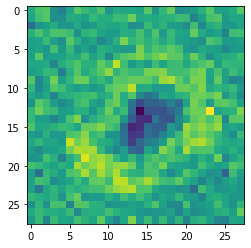

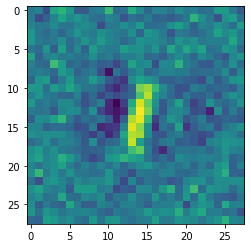

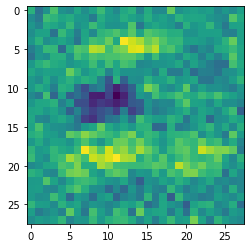

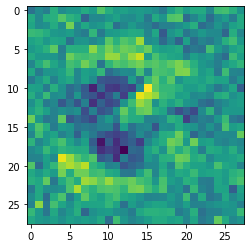

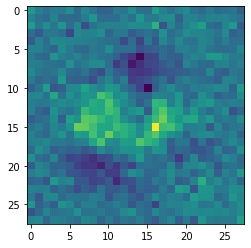

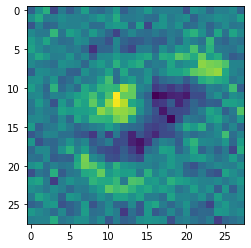

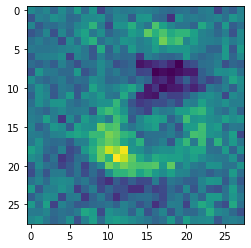

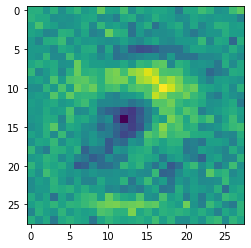

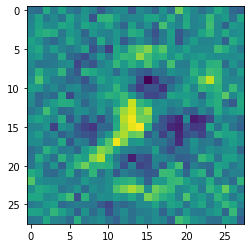

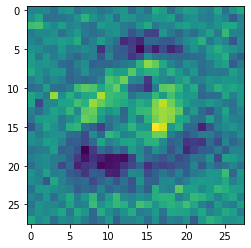

In [17]:
A = mnet.W_1.detach().numpy()
B = mnet.W_2.detach().numpy()
print(np.shape(A), np.shape(B))
weight = A@B
weight_plot = []
for i in range(10):
    weight_plot.append(weight.T[i])
for i in range(len(weight_plot)):
    plt.imshow(np.reshape(weight_plot[i],(28,28)))
    plt.show()

In [18]:
criterion = torch.nn.CrossEntropyLoss()
mnet = NeuralNet(784,25,10)  # Instantiate network
eta = 1e-2              # Set learning rate (empirically derived)
for t in range(5000):   # run for 50000 epochs
    y_pred = mnet.forward(x_train)   # Make a prediction
    L = criterion(y_pred,y_train) + torch.sum(torch.abs(mnet.W_1))*1e-2+torch.sum(torch.abs(mnet.W_2**2))*1e-2    # Compute mse
    mnet.zero_grad()           # Clear gradient buffer
    L.backward()              # MAGIC: compute dL/d parameter
    for param in mnet.parameters:            # update parameters w/
        param.data -= eta*param.grad.data   # GD
        
    if t%100==0:         # Print loss    
        print(t,L.item())
    
  

0 18.157223358556955
100 16.141673013919608
200 14.32075690016775
300 12.661761596071303
400 11.16197486520577
500 9.826554633479246
600 8.640213794207456
700 7.592669910321178
800 6.674801761967589
900 5.879889161415577
1000 5.201249268607132
1100 4.627362629282976
1200 4.145703981992705
1300 3.7436979422521004
1400 3.4071533777467877
1500 3.130481101362572
1600 2.9072230344402734
1700 2.7263404175274424
1800 2.58171076966424
1900 2.4637856753523986
2000 2.3675836595795663
2100 2.289070086487021
2200 2.2257607929221863
2300 2.1736622709423497
2400 2.1313842146718485
2500 2.096288793818024
2600 2.0684520432475075
2700 2.0461154088323448
2800 2.0270552734217504
2900 2.0104617341157107
3000 1.9959517284364972
3100 1.9834746990629604
3200 1.9725096287421735
3300 1.9632290422317789
3400 1.954930388213305
3500 1.94763071194497
3600 1.9412464239949574
3700 1.9352609528295357
3800 1.929815472857459
3900 1.924773711871234
4000 1.9199782170924689
4100 1.9156587811884034
4200 1.9115232707911483


In [19]:
Validation = np.zeros(2)
y_predTest = mnet.forward(x_test)
for i in range(1,len(y_predTest)):
    if torch.argmax(y_predTest[i])==y_test[i]:
        Validation[0]+=1;
    else:
        Validation[1]+=1;
Validation

array([947., 302.])

(784, 25) (25, 10)


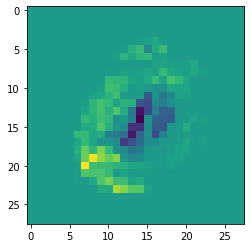

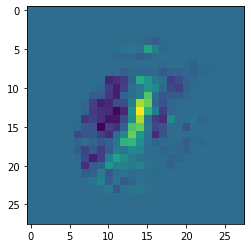

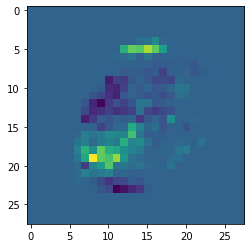

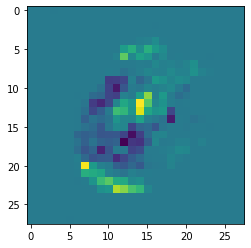

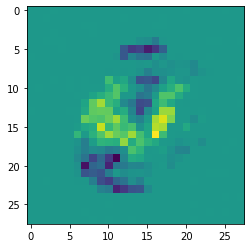

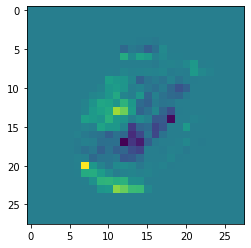

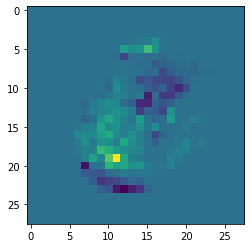

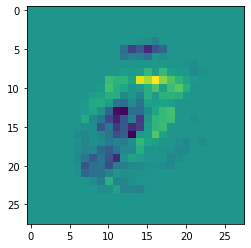

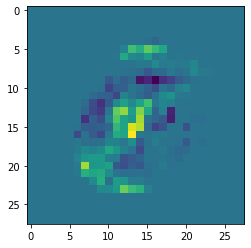

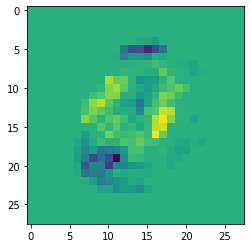

In [20]:
A = mnet.W_1.detach().numpy()
B = mnet.W_2.detach().numpy()
print(np.shape(A), np.shape(B))
weight = A@B
weight_plot = []
for i in range(10):
    weight_plot.append(weight.T[i])
for i in range(len(weight_plot)):
    plt.imshow(np.reshape(weight_plot[i],(28,28)))
    plt.show()

## More exotic forms of regularization
We'll do the following together in class, so no need to do anything on your part.

Direct manipulation of weights is perhaps the most obvious way of making the model parameters behave in the way that we would like them to, but they don't often help much on problems of fundamental interest.  Perhaps that's because there's a bit of a jump between "Make the $L_1$ norm small" and "Don't overfit the data." More interesting mechanisms for regularization exist that force the model to perform the latter task in somewhat more direct and clever ways.

If neural networks can (however tenuously) be thought of as an analog of an animal brain, then overfitting is reasonably well described as memorization.  For the student taking a test, instructors would prefer the student be able to answer a question in a constructive way by understanding the premise of the question being asked and thoughtfully constructing a response.  This is desirable because this mechanism *does not depend upon the specific way in which the question was asked*.  An alternative mechanism that less desirable students have been using forever is memorization: if the exact wording of the question (and its answer) are known beforehand, one can simply relate question to answer with no deeper intermediate analysis.  This latter is typically a great strategy for achieving training set accuracy, but very poor for test set accuracy.  

In the context of neural networks, these models often have sufficient degrees of freedom to simply memorize inputs.  As an extreme example, if the number of hidden layer nodes is similar to the number of data points, then weights can be adjusted such that exactly one hidden layer node gets activated for exactly one training example, and that hidden layer nodes has non-zero weight to exactly one softmax input.  Thus we have a network that sees a particular pattern of pixels (that it's seen before), and knows that that particular pattern corresponds to (say) a seven.  *Critically, come test time, a correct classification is only possible if the input is (nearly) exactly the same as what the network memorized*.  The useful capacity to weigh the contributions of different features is lost.

*Dropout* is a mechanism for ensuring that the above scenario does not occur.  It works as follows: for each training step, we select a random subset of nodes in a layer that we would like to apply dropout to (sometimes a hidden layer, sometimes an input layer, sometimes both), and *turn that node off*, i.e. set its output to zero.  This can be visualized with a classic plot from the [original paper by Srivastava et al.](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer) way back in 2014.

<img src="images/dropout.png">
Since the node is turned off, its forward mode output is equal to zero, which causes the gradient of any weights directly connected to it to be zero (**Can you show that this is true?**).  *Thus, the neural network is forced to learn to operate without only a random subset of its features available to it at any given time.* If only a random subset of features are available, then the network cannot rely on any given pattern, and thus it cannot simply memorize the training data! (A clever instructor might be able to develop questions that are similarly un-memorizable for their human pupils).  At test time, we don't drop nodes (that would be silly.  Why have them at all then?), but we do scale their outputs by the probability that they were dropped during the training process.  

Then dropout is easy to apply in pytorch: all we need to do is to instantiate a dropout layer and apply it after our activation function.  This essentially picks a random subset of the nodes with proportion $p$, and zeros out their output.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        """
        This method is where you'll want to instantiate parameters.
        we do this by creating two linear transformation functions, l1 and l2, which 
        have encoded in it both the weight matrices W_1 and W_2, and the bias vectors
        """
        super(Net,self).__init__()
        self.l1 = nn.Linear(784,128) # Transform from input to hidden layer
        self.l2 = nn.Linear(128,10)
        
        # Instantiate dropout layers
        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.5)
   
    def forward(self,x):
        """
        This method runs the feedforward neural network.  It takes a tensor of size m x 784,
        applies a linear transformation, applies a sigmoidal activation, applies the second linear transform 
        and outputs the logits.
        """
        # Apply dropout to the input
        xd = self.dropout_1(x)
        a1 = self.l1(xd)
        z1 = torch.sigmoid(a1)
        
        # Apply dropout to the hidden layer
        z1d = self.dropout_2(z1)
        a2 = self.l2(z1)

        return a2

Here I'm going to do a bit of fancy stuff that we haven't considered yet explicitly (namely, running the model on my GPU and also only processing small chunks of training data at a time, so-called minibatch gradient descent).

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True)
X/=255.
y = y.astype(int)
X,X_test,y,y_test = train_test_split(X,y,test_size=10000)

# Extract number of data points, and the height and width of the images for later reshaping
m = X.shape[0]
n = X.shape[1]

h = 28
w = 28

N = 10

X = torch.from_numpy(X)
X_test = torch.from_numpy(X_test)
y = torch.from_numpy(y)
y_test = torch.from_numpy(y_test)

X = X.to(torch.float32)
X_test = X_test.to(torch.float32)
y = y.to(torch.long)
y_test = y_test.to(torch.long)

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

X = X.to(device)
X_test = X_test.to(device)
y = y.to(device)
y_test = y_test.to(device)

training_data = TensorDataset(X,y)
test_data = TensorDataset(X_test,y_test)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 256
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size, 
                                           shuffle=False)


Now, let's train the model using a similar loop to what you've implemented.

In [ ]:
model = Net()
model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

epochs = 50

total_train = 0
correct_train = 0
# Loop over the data
for epoch in range(epochs):
    model.train()
    # Loop over each subset of data
    for d,t in train_loader:

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)    

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())
        
    model.eval()
    # After each epoch, compute the test set accuracy
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),100.*correct_train/total_train,100.*correct/total)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
params = [p for p in model.l1.parameters()]
W1_dropout = params[0].cpu().detach().numpy().T

fig,axs = plt.subplots(nrows=1,ncols=6)
fig.set_size_inches(20,8)
for i in range(6):
    #axs[0,i].imshow(W1_noreg[:,np.random.randint(W1_noreg.shape[1])].reshape((h,w)))
    axs[i].imshow(W1_dropout[:,np.random.randint(W1_dropout.shape[1])].reshape((h,w)))

Dropout has worked (in a way that $L_2$ or $L_1$ regularization clearly did not): we get close to 98.3% test set accuracy.

# Data Augmentation
Dropout is a fantastic tool for encouraging neural networks to not overfit, but it is still suboptimal when compared to the one and only true solution to overfitting: get more data.  This is the one method that always works to justify the inclusion of more complex and powerful models.  The problem of course is that it's often expensive and sometimes impossible.  For example, with the MNIST dataset, we can't just go collect new handwritten digits...  Or can we?

Consider the following digit images:

In [ ]:
fig,axs = plt.subplots(nrows=1,ncols=2)
axs[0].imshow(X[5].cpu().reshape((28,28)))

# What is being done here?
from scipy.ndimage import rotate
axs[1].imshow(rotate(X[5].cpu().reshape((28,28)),25,order=1,reshape=False))
plt.show()

These are both, of course, still the same digit, and that is immediately recognizable to your human visual processing system because somehow it's learned to be *rotationally invariant*.  However, we haven't explicitly taught our neural network that same property: all the rotational invariance it has learned is that which comes from the 60k training examples.  We can force it to learn that property by feeding the network training examples that we have explicitly rotated (probably randomly, and probably within a set range of viable rotations.  **What happens if we train on data that is randomly rotated in the full 360 degrees?**

The above process is called *data augmentation*, and is typically done in an *on-line* capacity, which means that as we load mini-batches, we perform some random transformation on each data point, then pass it on to the network as usual.  **Besides rotation, what kinds of transformations can you imagine that we might do on image data?**  We can implement this in pytorch with a custom data loader.

In [ ]:
import torch
from torch.utils.data import Dataset,TensorDataset
from torchvision import transforms

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True)
X/=255.
y = y.astype(int)
X,X_test,y,y_test = train_test_split(X,y,test_size=10000)

X = torch.from_numpy(X)
X_test = torch.from_numpy(X_test)
y = torch.from_numpy(y)
y_test = torch.from_numpy(y_test)

X = X.to(torch.float32)
X_test = X_test.to(torch.float32)
y = y.to(torch.long)
y_test = y_test.to(torch.long)

### NOTE THAT WE ARE NOT YET PLACING OBJECTS ON GPU ###

In [ ]:
# Define a random transform (20 degree rotation, 3 pixel translation, 
# scaling between 90% and 110%, and a 10 degree shear over the x-axis) 
transform = transforms.RandomAffine(20,translate=(0.1,0.1),scale=(0.9,1.1),shear=10)#,transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip()]

# Custom dataset object
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        # Define a __getitem__ method to be called by the 
        # mini-batch loader 
        
        x = self.tensors[0][index]

        if self.transform:
            # reshape data, apply transform, reflatten
            x = x.reshape((28,28))
            x = transforms.ToPILImage()(x)
            x = self.transform(x)
            x = transforms.ToTensor()(x)
            x = x.flatten()
            #print(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

training_data = CustomTensorDataset([X,y],transform=transform)
test_data = CustomTensorDataset([X_test,y_test])

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size, 
                                           shuffle=True,num_workers=24)

batch_size = 256
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size, 
                                           shuffle=False,num_workers=24)

In [ ]:
t = next(iter(train_loader))

import matplotlib.pyplot as plt
fig,axs = plt.subplots(nrows=5,ncols=6)
axs = axs.ravel()
for i,ax in enumerate(axs):
    ax.imshow(t[0][i].reshape((28,28)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

n = 784
N = 10

class Net(nn.Module):
    def __init__(self):
        """
        This method is where you'll want to instantiate parameters.
        we do this by creating two linear transformation functions, l1 and l2, which 
        have encoded in it both the weight matrices W_1 and W_2, and the bias vectors
        """
        super(Net,self).__init__()
        self.l1 = nn.Linear(n,128) # Transform from input to hidden layer
        self.l2 = nn.Linear(128,N)



    
    def forward(self,x):
        """
        This method runs the feedforward neural network.  It takes a tensor of size m x 784,
        applies a linear transformation, applies a sigmoidal activation, applies the second linear transform 
        and outputs the logits.
        """
        a1 = self.l1(x)
        z1 = torch.sigmoid(a1)
        
        a2 = self.l2(z1)

        return a2

Unfortunately, this model takes alot longer to train, mostly due to the overhead of augmentation (there are new libraries that allow augmentation to be done quickly and in situ on the GPU in order to help deal with this bottleneck).  We'll load a pre-trained model to help us get to results more quickly.  

In [ ]:
model = torch.load(open('trained_with_augmentation.p','rb'))
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
epochs = 5

total_train = 0
correct_train = 0
# Loop over the data
for epoch in range(epochs):
    model.train()
    # Loop over each subset of data
    for d,t in train_loader:
        # Move batches to GPU
        d,t = d.to(device),t.to(device)

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)  

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())
        
    model.eval()
    # After each epoch, compute the test set accuracy
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        d,t = d.to(device),t.to(device)
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),100.*correct_train/total_train,100.*correct/total)

Data augmentation has gotten us to test set accuracies in excess of 98.5%!  This is a remarkable improvement for just jiggling our dataset a bit.  However, it makes sense why it works: the model never trains on the same data point twice, making memorization quite impossible.  Additionally, this property leads to some very compelling looking weight images.

In [ ]:
params = [p for p in model.parameters()]
W1 = params[0].cpu().detach().numpy().T
fig,axs = plt.subplots(nrows=1,ncols=6)
fig.set_size_inches(10,4)
for i in range(6):
    axs[i].imshow(W1[:,np.random.randint(W1.shape[1])].reshape((28,28)))

No pixel can ever really be relied upon to produce a definitive categorization, so the model has instead learned to recognize broader patterns that are more easily recognizable.  Interestingly, if you know something about classical image processing or numerical partial differential equations, some of the images above will look familiar: asymmetrical patches of positive and negative values are associated with taking the gradient of an image, while a positive patch surrounded by negative patches are analogous to taking the laplacian (essentially the second derivative, or *curvature* of an image).  We've long known that these are nice filters to apply for extracting relevant features from an image; our neural network has just learned these filters on its own!  This notion of *explicitly learning filters* to be applied to images (or any structured data, as we will see) for feature extraction turns out to be a very powerful idea that gives rise to the basis for the current state of the art in image processing (and various tasks in bioinformatics and audio analysis), the *convolutional neural network*, which we will talk about next week.

It's also fun to look at the effect of data augmentation on the Labelled Faces in the Wild dataset, as we get a little bit more robust features for facial recognition.  **What is the network looking for, when it can't rely on features being in a particular place?**

In [ ]:
lfw_model = torch.load(open('lfw_augmented.p','rb'))
params = [p for p in lfw_model.parameters()]
W1 = params[0].cpu().detach().numpy().T
fig,axs = plt.subplots(nrows=1,ncols=6)
fig.set_size_inches(10,4)
for i in range(6):
    axs[i].imshow(W1[:,np.random.randint(W1.shape[1])].reshape((50,37)))